In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("src/")

In [3]:
from datasets.tripadvisor import TripAdvisorDataset

dataset = TripAdvisorDataset(
        text_processor='word2vec', 
        text_processor_filters=['lowercase', 'stopwordsfilter'],
        embedding_path='data/embeddings/word2vec/glove.6B.50d.txt',
        data_path='data/'
        )

### Dawid-Skene

In [4]:
import models.dawid_skene as ds

#### Prepare data

In [5]:
def prepare_input(dataset, female_model, male_model, missing_value=-1):
    data = {}
    for data_point in dataset:
        annotator = data_point['annotator']
        question = data_point['text']
        annotation = data_point['label'].item()
        
        data[question] = {}
        #data[question]['truth'] =  [ annotation ]
        data[question]['female'] = [ female_model(data_point['embedding']).argmax().item() ]
        data[question]['male'] =   [ male_model(data_point['embedding']).argmax().item() ]
    return data

#### Load Pretrained Male, Female Models

In [6]:
import torch

In [7]:
def load_model_for_inference(path):
    from models.basic import BasicNetwork
    model = BasicNetwork(embedding_dim=50, label_dim=2)
    model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
    model.eval()
    
    return model

In [8]:
male_model_path = 'models/tripadvisor_pad100/male_basic_0.89060_batch64_lr8.299248182022548e-05_20200925-075432.pt'
female_model_path = 'models/tripadvisor_pad100/female_basic_0.89038_batch64_lr0.0003306989309627488_20200924-222149.pt'

In [9]:
male_model = load_model_for_inference(male_model_path)
female_model = load_model_for_inference(female_model_path)

#### Transform dataset

In [10]:
data = prepare_input(dataset, female_model, male_model)

In [11]:
patients, observers, classes, counts, class_marginals, error_rates, patient_classes = ds.run(data)

num Patients: 13707
Observers: ['female', 'male']
Classes: [0, 1]
Iter	log-likelihood	delta-CM	delta-ER
1 	 -14253.315573351305
2 	 -14250.461496730466 	0.000038	0.025316
3 	 -14250.418910985853 	0.000005	0.003141
4 	 -14250.41821090512 	0.000001	0.000403
5 	 -14250.41819926299 	0.000000	0.000052
6 	 -14250.418199067128 	0.000000	0.000007
Class marginals
[0.45 0.55]
Error rates
[[[0.94 0.06]
  [0.06 0.94]]

 [[0.92 0.08]
  [0.05 0.95]]]
Incidence-of-error rates
[[0.42 0.03]
 [0.03 0.52]]
[[0.41 0.04]
 [0.02 0.53]]


#### Visualize

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_error_matrices(error_rates, observers, class_marginals):
    nrows, ncols = int(math.ceil(len(observers)/3)), 3
    f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5,nrows*5))
    for i, obs in enumerate(observers):
        error_rate = error_rates[i]
        incidence_of_error_rate = class_marginals * error_rate
        
        sns.heatmap(error_rate, vmin=0, vmax=1, annot=True, cbar=False, ax=axs.flat[i])
        axs.flat[i].set_title(f'Error rate \n {obs}')
        axs.flat[i].set_xlabel('Observed label')
        axs.flat[i].set_ylabel('Latent truth')
    plt.show(f)

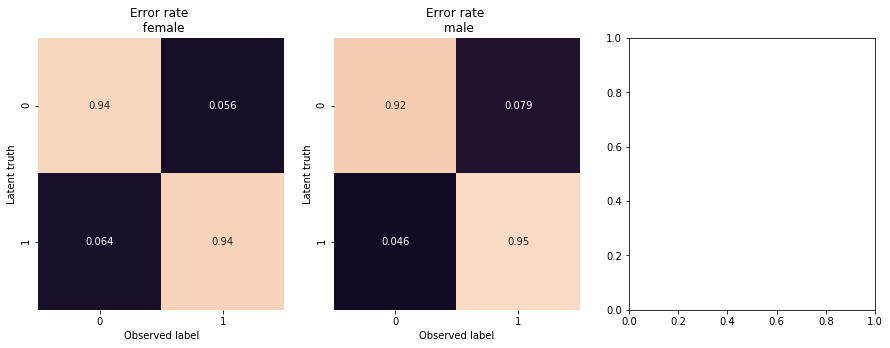

In [13]:
plot_error_matrices(error_rates, observers, class_marginals)